#Multi-group Neutronics Algorithm

In [1]:
%reset -f

###Importing the necessary packages

numpy for arrays

pyplot for plotting

json for loading in the energy data from the xs library


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json

##Load In the Data

Spectrum Data from a csv obtained from Serpent

Cross-section data from a json obtained from xsplotter

In [4]:
with open('EnergyBins.csv','rb') as EnergyBins,\
open('xsplot_download.json','r') as XS:
    SpectrumData = np.loadtxt(EnergyBins,delimiter=',')
    msnbE = SpectrumData[:,0]*1e6 #eV
    msnbPhi = SpectrumData[:,1] #n/cm2.s
    
    Xe = 0
    U  = 1
    jsonXS = json.load(XS)
    
    Xe135E = np.array(jsonXS[Xe]["energy"]) #eV 
    Xe135XS = np.array(jsonXS[Xe]["cross section"]) #barn
    U235E = np.array(jsonXS[U]["energy"]) #eV
    U235XS = np.array(jsonXS[U]["cross section"]) #barn

     

###Plotting Setup

x-axis boundaries are determined by the domain of the data sets

Group boundaries are selected based on the shape of the curves. Your multi-group calculations are more meaningful and the algorithm yields better results when group boundaries are placed where the behavior of the neutron spectrum or cross-section changes. For example the boundary between resonance and epithermal neutrons was placed where the neutron flux starts falling off, and the boundary between fast and resonance neutrons was placed at the energy where the $^{135}Xe$ cross-section drops by several orders of magnitude

In [5]:
#Plot Params
xmin,xmax = 5e-6,5e7
lw = 1

#Group Bounds
th = 0.0025
ep = 0.1
fs = 600
uf = 2e6

#Algorithm for centering group labels
def logmid(a,b):
    return np.sqrt(a*b)

###Plotting the raw spectrum data and cross-section data

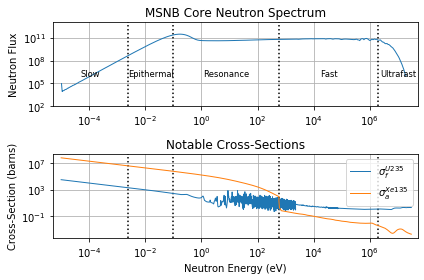

In [8]:
fig,ax = plt.subplots(2,1)

#Group Bounds
ax[1].axvline(th, linestyle='dotted',color='black')
ax[1].axvline(ep, linestyle='dotted',color='black')
ax[1].axvline(fs, linestyle='dotted',color='black')
ax[1].axvline(uf, linestyle='dotted',color='black')
ax[0].axvline(th, linestyle='dotted',color='black')
ax[0].axvline(ep, linestyle='dotted',color='black')
ax[0].axvline(fs, linestyle='dotted',color='black')
ax[0].axvline(uf, linestyle='dotted',color='black')

#Group Labels
label_ycoord = 1e6
fontsize = 'small'
ax[0].text(logmid(xmin,th),label_ycoord,'Slow',horizontalalignment='center',size=fontsize)#
ax[0].text(logmid(th,ep),label_ycoord,'Epithermal',horizontalalignment='center',size=fontsize)#
ax[0].text(logmid(ep,fs),label_ycoord,'Resonance',horizontalalignment='center',size=fontsize)#
ax[0].text(logmid(fs,uf),label_ycoord,'Fast',horizontalalignment='center',size=fontsize)#
ax[0].text(logmid(uf,xmax),label_ycoord,'Ultrafast',horizontalalignment='center',size=fontsize)#

ax[0].plot(msnbE,msnbPhi,linewidth=lw)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlim(xmin,xmax)
ax[0].set_ylim(1e2,1e13)
ax[0].set_ylabel('Neutron Flux')
ax[0].set_title('MSNB Core Neutron Spectrum')
ax[0].grid()

ax[1].plot(U235E,U235XS,label='$\sigma_{f}^{U235}$',linewidth=lw)
ax[1].plot(Xe135E,Xe135XS,label='$\sigma_{a}^{Xe135}$',linewidth=lw)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlim(xmin,xmax)
ax[1].set_ylabel('Cross-Section (barns)')
ax[1].set_xlabel('Neutron Energy (eV)')
ax[1].set_title('Notable Cross-Sections')
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.savefig('Spectrum.png')


##Creating a 1-to-1 correspondence between the cross-section data and the neutron spectrum data

###How long are the arrays we are working with?

In [9]:
print(f'Core Spectrum {SpectrumData[:,1].size} data points')
print(f'U235 Fission Cross-section {U235E.size} data points')
print(f'Xe135 Poison Cross-section {Xe135E.size} data points')

Core Spectrum 500 data points
U235 Fission Cross-section 76027 data points
Xe135 Poison Cross-section 1090 data points


###Function that returns the index for the array energy value closest to the input energy value


In [10]:
def get_index(array,value):
    diff_array = array-value
    abs_array = np.abs(diff_array)
    min = np.min(abs_array)
    index_tuple = np.where(abs_array == min,)
    index = index_tuple[0][0]
    if array[index]<value:
        index+=1
    return index




###Function that returns the weighted average cross-sections over the energy bin 

$$
\bar{\sigma}_{\phi} = \frac{\sum_{i=0}^{n}{\sigma_i \Delta E}}{\sum_{i=0}^{n}{\Delta E}}
$$

In [11]:
def get_weighted500(energy):
    i = get_index(msnbE,energy)
    left = get_index(U235E,msnbE[i-1])
    right = get_index(U235E,msnbE[i])
    if left >= right:
        U_ave = U235XS[right]
    else:
        dE = U235E[left:right] - U235E[left-1:right-1]
        dEsigma = dE*U235XS[left:right]
        U_ave = np.sum(dEsigma)/np.sum(dE)
    left = get_index(Xe135E,msnbE[i-1])
    right = get_index(Xe135E,msnbE[i])
    if left >= right:
        Xe_ave = Xe135XS[right]
    else:
        dE = Xe135E[left:right] - Xe135E[left-1:right-1]
        dEsigma = dE*Xe135XS[left:right]
        Xe_ave = np.sum(dEsigma)/np.sum(dE)
    return (Xe_ave,U_ave)


###Correspond Cross Section Data to 500 data points (length of neutron spectrum array)

In [12]:
Xe135XS500 = np.zeros(msnbE.size)
U235XS500 = np.zeros(msnbE.size)

for i,E in enumerate(msnbE):
    XS = get_weighted500(E)
    Xe135XS500[i]=XS[Xe]
    U235XS500[i]=XS[U]


###Plotting the 500 group approximation cross-section

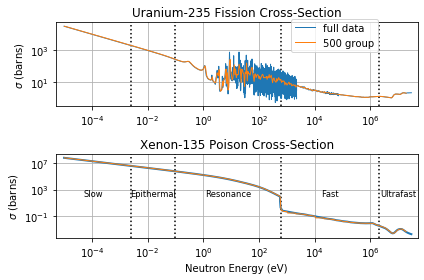

In [13]:
fig,ax = plt.subplots(2,1)

#Group Bounds
ax[1].axvline(th, linestyle='dotted',color='black')
ax[1].axvline(ep, linestyle='dotted',color='black')
ax[1].axvline(fs, linestyle='dotted',color='black')
ax[1].axvline(uf, linestyle='dotted',color='black')
ax[0].axvline(th, linestyle='dotted',color='black')
ax[0].axvline(ep, linestyle='dotted',color='black')
ax[0].axvline(fs, linestyle='dotted',color='black')
ax[0].axvline(uf, linestyle='dotted',color='black')

#Group Labels
label_ycoord = 1e2
fontsize = 'small'
ax[1].text(logmid(xmin,th),label_ycoord,'Slow',horizontalalignment='center',size=fontsize)#
ax[1].text(logmid(th,ep),label_ycoord,'Epithermal',horizontalalignment='center',size=fontsize)#
ax[1].text(logmid(ep,fs),label_ycoord,'Resonance',horizontalalignment='center',size=fontsize)#
ax[1].text(logmid(fs,uf),label_ycoord,'Fast',horizontalalignment='center',size=fontsize)#
ax[1].text(logmid(uf,xmax),label_ycoord,'Ultrafast',horizontalalignment='center',size=fontsize)#

ax[0].plot(U235E,U235XS,label='full data',linewidth=lw)
ax[0].plot(msnbE,U235XS500,label='500 group',linewidth=lw)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlim(xmin,xmax)
ax[0].set_ylabel('$\sigma$ (barns)')
ax[0].set_title('Uranium-235 Fission Cross-Section')
ax[0].grid()
ax[0].legend(loc=(0.65,0.65))

ax[1].plot(Xe135E,Xe135XS,label='full data',linewidth=2*lw)
ax[1].plot(msnbE,Xe135XS500,label='500 group',linewidth=lw)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlim(xmin,xmax)
ax[1].set_ylabel('$\sigma$ (barns)')
ax[1].set_xlabel('Neutron Energy (eV)')
ax[1].set_title('Xenon-135 Poison Cross-Section')
ax[1].grid()

plt.tight_layout()
plt.savefig('500Group.png')

##Obtaining representative energy group cross-sections

###Function that returns the weighted average cross-section for each neutron group

$$
\bar{\sigma}_{group} = \frac{\sum_{i=0}^{n}{\sigma_i \phi_{i}}}{\sum_{i=0}^{n}{\phi_i}}
$$

In [14]:
def get_weighted_flux(left,right): 
    phi = msnbPhi[left:right]
    sigmaXe = Xe135XS500[left:right]
    sigmaU = U235XS500[left:right]
    phiXe = phi*sigmaXe
    phiU = phi*sigmaU
    
    Xe_ave = np.sum(phiXe)/np.sum(phi)
    U_ave =  np.sum(phiU)/np.sum(phi)
    return (Xe_ave,U_ave)


###Calculate the Weighted Average Cross-sections for each group

In [15]:
midpoints = np.array([logmid(xmin,th),logmid(th,ep),logmid(ep,fs),logmid(fs,uf),logmid(uf,xmax)])

averages = np.array([get_weighted_flux(0,get_index(msnbE,th)),
                     get_weighted_flux(get_index(msnbE,th),get_index(msnbE,ep)),
                     get_weighted_flux(get_index(msnbE,ep),get_index(msnbE,fs)),
                     get_weighted_flux(get_index(msnbE,fs),get_index(msnbE,uf)),
                     get_weighted_flux(get_index(msnbE,uf),-1)])

intersectionsXe = np.zeros(midpoints.size)
intersectionsU = np.zeros(midpoints.size)

for i,ave in enumerate(averages):
    intersectionsXe[i] = msnbE[get_index(Xe135XS500,ave[Xe])]
    intersectionsU[i] = msnbE[get_index(U235XS500,ave[U])]
    
#special cases where the first index returned does not correspond to the center of mass of the group
i , j = get_index(msnbE,fs) , get_index(msnbE,uf)
intersectionsU[-2] = msnbE[get_index(U235XS500[i:j],averages[-2][U])+i]
intersectionsU[-1] = msnbE[get_index(U235XS500[j:],averages[-1][U])+j]


###Plotting with 5 group cross-sections marked

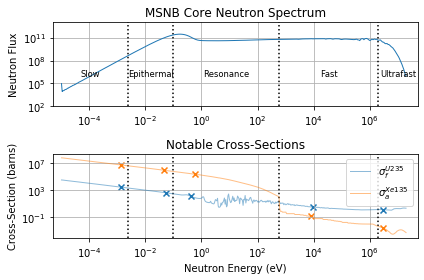

In [16]:
fig,ax = plt.subplots(2,1)

#Group Bounds
ax[1].axvline(th, linestyle='dotted',color='black')
ax[1].axvline(ep, linestyle='dotted',color='black')
ax[1].axvline(fs, linestyle='dotted',color='black')
ax[1].axvline(uf, linestyle='dotted',color='black')
ax[0].axvline(th, linestyle='dotted',color='black')
ax[0].axvline(ep, linestyle='dotted',color='black')
ax[0].axvline(fs, linestyle='dotted',color='black')
ax[0].axvline(uf, linestyle='dotted',color='black')

#Group Labels
label_ycoord = 1e6
fontsize = 'small'
ax[0].text(logmid(xmin,th),label_ycoord,'Slow',horizontalalignment='center',size=fontsize)#
ax[0].text(logmid(th,ep),label_ycoord,'Epithermal',horizontalalignment='center',size=fontsize)#
ax[0].text(logmid(ep,fs),label_ycoord,'Resonance',horizontalalignment='center',size=fontsize)#
ax[0].text(logmid(fs,uf),label_ycoord,'Fast',horizontalalignment='center',size=fontsize)#
ax[0].text(logmid(uf,xmax),label_ycoord,'Ultrafast',horizontalalignment='center',size=fontsize)#

ax[0].plot(msnbE,msnbPhi,linewidth=lw)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlim(xmin,xmax)
ax[0].set_ylim(1e2,1e13)
ax[0].set_ylabel('Neutron Flux')
ax[0].set_title('MSNB Core Neutron Spectrum')
ax[0].grid()
 
o = 0.5 #opacity
ax[1].plot(msnbE,U235XS500,label='$\sigma_{f}^{U235}$',linewidth=lw,alpha=o)
ax[1].plot(msnbE,Xe135XS500,label='$\sigma_{a}^{Xe135}$',linewidth=lw,alpha=o)
ax[1].scatter(intersectionsU,averages[:,U],marker='x')
ax[1].scatter(intersectionsXe,averages[:,Xe],marker='x')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlim(xmin,xmax)
ax[1].set_ylabel('Cross-Section (barns)')
ax[1].set_xlabel('Neutron Energy (eV)')
ax[1].set_title('Notable Cross-Sections')
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.savefig('5Group.png')

###Export Group Fluxes

In [19]:
slow = msnbPhi[0:get_index(msnbE,th)]
epithermal = msnbPhi[get_index(msnbE,th):get_index(msnbE,ep)]
resonance = msnbPhi[get_index(msnbE,ep):get_index(msnbE,fs)]
fast = msnbPhi[get_index(msnbE,fs):get_index(msnbE,uf)]
ultrafast = msnbPhi[get_index(msnbE,uf):]

fluxgroups = np.array([slow,epithermal,resonance,fast,ultrafast],dtype=object)
groupfluxes = np.zeros(fluxgroups.size)

for i,fluxgroup in enumerate(fluxgroups):
    groupfluxes[i] = np.sum(fluxgroup)
    

print('Group Fluxes')
print(f'{groupfluxes} n/cm2-s')
print('Total Flux')
print(f'{np.sum(groupfluxes):1E} n/cm2-s')   


Group Fluxes
[3.99963588e+09 3.26277073e+12 1.21983907e+13 9.35926220e+12
 5.07730152e+11] n/cm2-s
Total Flux
2.533215E+13 n/cm2-s


###Export Group Cross-Sections

In [20]:
print('Uranium-235 Fission Cross-Sections')
print(f'{averages[:,U]} barns')
print('Xenon-135 Fission Cross-Sections')
print(f'{averages[:,Xe]} barns')

Uranium-235 Fission Cross-Sections
[2.67587434e+03 4.10863035e+02 1.16264339e+02 3.23301394e+00
 1.23489613e+00] barns
Xenon-135 Fission Cross-Sections
[5.05289755e+06 8.25151735e+05 2.28373360e+05 1.27941106e-01
 2.51010644e-03] barns


###Checking the power

In [21]:
    #FUEL... 18mol% HALEU-UF4 in FLiNaK @ 19.75% enrichment
    mole = 0.18
    enrichment = 0.1975 
    
    Avo = 6.0221408e23
    mass_den = 3.60510 #g/cm3 @915K
    MW = 35.555
    N = Avo*mass_den/MW #atoms/cm3
    basis = 5*mole+2*(1-mole)
    molefrac235 = mole/basis*enrichment
    #Sigma_F = 1e-24*averages[:,U]*N*molefrac235 #cm-1
    Sigma_F = 1e-24*U235XS500*N*molefrac235 #cm-1
    #FissRate = np.sum(Sigma_F*groupfluxes)
    FissRate = np.sum(Sigma_F*msnbPhi) #fiss/cm3-s
    AveFiss = 3.2e-11 #J/fission
    PowDen = FissRate*AveFiss #W/cm3 = MW/m3
    Volume = 4.29116E-1
    Power = PowDen*Volume
    
    print(f'{Power:,.21f} MW')

32.863570641008394090932 MW
